In [1]:
# Author: Samantha Tetef
# Created: 1.29.20
# Title: XESML

# This notebook analyzes hundreds of sulfur compounds PCA and a VAE

In [2]:
from utils import *

from random import randint

import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import backend as K
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
from keras.activations import*
from keras.models import load_model

from sklearn import neighbors
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, NMF
from sklearn.manifold import TSNE

In [3]:
%%javascript
 IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
 }

<IPython.core.display.Javascript object>

## Intro figures

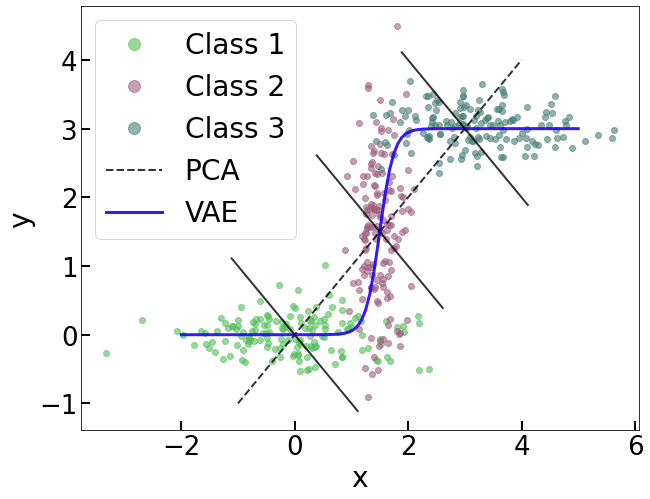

In [4]:
def sigma(x):
    return (1/(1 + np.exp(-8*(x-1.5))))*3

n = 150
np.random.seed(42)

c1 = np.random.multivariate_normal([0.,0.], [[1.05,0.0],[0.0,0.07]], size=(n))
c2 = np.random.multivariate_normal([1.5,1.5], [[.07,0.],[0.,.95]], size=(n))
eps = np.random.normal(0, 0.3, size=(n))
x2 = np.linspace(0., 3, n)
c3 = np.random.multivariate_normal([3.,3.], [[1.05,0.0],[0.0,0.07]], size=(n))

fig, ax = plt.subplots(figsize=(10,7.8))

# plotting data
plt.plot(c1[:,0], c1[:,1], '.', c=COLORS[3], label='Class 1', alpha=0.6, markersize=12)
plt.plot(c2[:,0], c2[:,1], '.', c='#9F5F80', label='Class 2', alpha=0.6, markersize=12)
plt.plot(c3[:,0], c3[:,1], '.', c='#488077', label='Class 3', alpha=0.6, markersize=12)

plt.plot(np.linspace(-1,4,10), np.linspace(-1,4,10), '--', c='k', linewidth = 2, alpha=0.8, label='PCA')

a, b, c = np.linspace(-2,2,10), np.linspace(-0.5,3.5,10), np.linspace(1,5,10)

# VAE
color1 = '#000080'
color1 = '#2200ff' 
lw = 3
x = np.linspace(-2,5,100)
plt.plot(x, sigma(x), '-', c=color1, linewidth=lw, alpha=0.9, label='VAE')

# PCA
color2 = 'k'
alp = 0.8
plt.plot(a[2:8], -a[2:8], '-', c=color2, linewidth=2, alpha=alp)
plt.plot(b[2:8], -b[2:8]+3, '-', c=color2, linewidth=2, alpha=alp)
plt.plot(c[2:8], -c[2:8]+6, '-', c=color2, linewidth=2, alpha=alp)

plt.xlabel('x', fontsize=28)
plt.ylabel('y', fontsize=28)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax.tick_params(direction='in', width=2, length=9)
plt.legend(fontsize=28, markerscale=2)

plt.show()

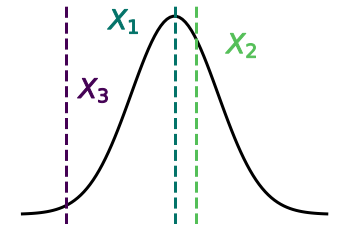

In [5]:
x = np.linspace(-3.5,3.5,100)
y = scipy.stats.norm.pdf(x)

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(x, y, 'k-', linewidth=3)
plt.axvline(x=0, color=COLORS[2], linestyle='--', linewidth=3)
plt.axvline(x=0.5, color=COLORS[3], linestyle='--', linewidth=3)
plt.axvline(x=-2.5, color=COLORS[0], linestyle='--', linewidth=3)
plt.plot(-1.2, 0.39, marker='$X_1$', markersize=30, color=COLORS[2])
plt.plot(1.5, 0.34, marker='$X_2$', markersize=30, color=COLORS[3])
plt.plot(-1.9, 0.25, marker='$X_3$', markersize=30, color=COLORS[0])
# plt.plot(2.3, 0.25, marker='s', markersize=20, color=COLORS[3])
# plt.plot(-2, 0.33, marker='*', markersize=30, color=COLORS[2])

plt.axis('off')
    
plt.show()

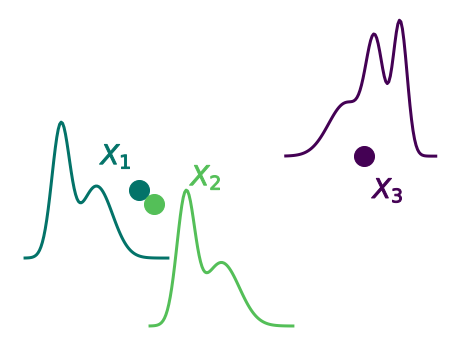

In [6]:
x1 = np.linspace(-2,2,100)
y1 = scipy.stats.norm.pdf(x1, loc=0, scale=0.45)
y1 += scipy.stats.norm.pdf(x1, loc=-1., scale=0.25)

x2 = np.linspace(-2,2,100)
y2 = scipy.stats.norm.pdf(x2, loc=0., scale=0.5)
y2 += scipy.stats.norm.pdf(x2, loc=-1., scale=0.25)

x3 = np.linspace(-0.2,4.,100)
y3 = scipy.stats.norm.pdf(x3, loc=3., scale=0.2)
y3 += scipy.stats.norm.pdf(x3, loc=2.3, scale=0.25)
y3 += scipy.stats.norm.pdf(x3, loc=1.5, scale=0.5)

y1 = y1/np.max(y1)
y2 = y2/np.max(y2)
y3 = y3/np.max(y3)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x1-3, 2*y1 + 1, '-', linewidth=3, color=COLORS[2])
ax.plot(x2+0.5, 2*y2, '-', linewidth=3, color=COLORS[3])
ax.plot(x3+2.5, 2*y3 + 2.5, '-', linewidth=3, color=COLORS[0])

plt.plot(-2.5, 2.5, marker='$X_1$', markersize=30, color=COLORS[2])
plt.plot(0., 2.2, marker='$X_2$', markersize=30, color=COLORS[3])
plt.plot(5.1, 2, marker='$X_3$', markersize=30, color=COLORS[0])

plt.plot(-1.8, 2, marker='o', markersize=20, color=COLORS[2])
plt.plot(-1.4, 1.8, marker='o', markersize=20, color=COLORS[3])
plt.plot(4.5, 2.5, marker='o', markersize=20, color=COLORS[0])

plt.axis('off')

plt.xlim(-5.5,7)
plt.ylim(-0.1,4.7)
    
plt.show()

In [7]:
for c in COLORS:
    print(to_hex(c))

#440154
#3b66b3
#037369
#54bf58
#e4ce0c


# Reading in spectra

Reading in compound names from lists (text files)

In [8]:
# setting up directory
ROOTDIR = os.getcwd()
TYPEdir = "Categories/"

### Creating dictionary list of compound categories

Spectrum must have been preprocessed using the SpectraFromDat python script

In [9]:
Data = get_XES(Types, TYPEdir)
N = len(Data)
NAMES = get_Property(Data, 'name')

PROPERTIES = ['oxy', 'Type', 'category']
Labels = []
for PROPERTY in PROPERTIES:
    Labels.append(get_Property(Data, PROPERTY))

# XES

Separating energy, which should be the same for all XES spectra, and the spectra itself

In [10]:
XES = np.array(get_Property(Data, 'XES'))
XESenergy = XES[0,0,:]

X = np.array(get_Property(Data, 'XES'))[:,1,:]

SCALING_FACTOR = np.max(X)
# peak normalizing spectra overnetire ensemble!
X = X/SCALING_FACTOR

# TEST

In [11]:
# test_list = get_text_in_file('Categories/TEST.txt').split('\n')
test_list = ['2-Fluorocyclohexane-1-thiol']

TESTData = get_TEST_Data(test_list, directory='XES')
TEST_NAMES = get_Property(TESTData, 'Name')

TEST_XES_tuple = np.array(get_Property(TESTData, 'Spectra'))
TEST_XES = TEST_XES_tuple[:,1,:]

TEST_XES = TEST_XES/SCALING_FACTOR

print(len(TEST_NAMES))

1


In [12]:
def esnip(trans, emin, spectrum):
    x,y = trans
    x = x - 18.6
    for i, e in enumerate(x):
        if e >= emin:
            break
    x = x[i:]
    y = y[i:]
    
    if x[-1] < 0:
        return x[:-1], y[:-1]
    
    y = y/np.max(y)
    
    return x, y*np.max(spectrum)

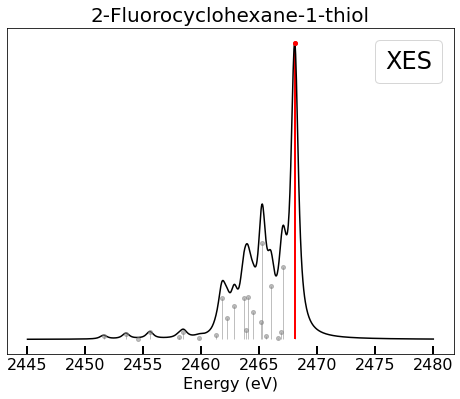

In [13]:
name='2-Fluorocyclohexane-1-thiol'
index = TEST_NAMES.index(name)

x = TEST_XES[index]/SCALING_FACTOR
trans = TESTData[index]['Transitions']

trans = esnip(trans, 2400, x)
trans_cut = [trans[0][1:], trans[1][1:]]
plot_spectrum_and_trans(trans_cut, [XESenergy, x], f'{name}', figsize=(8,6), label='XES', ylab=False, emp=[-1])

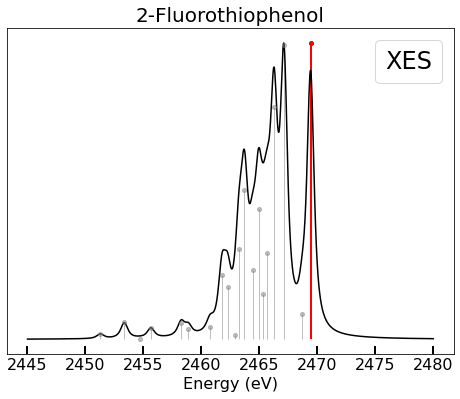

In [14]:
name= '2-Fluorothiophenol'
index = NAMES.index(name)

x = get_Spectrum(Data, name)[1]/SCALING_FACTOR
trans = Data[index]['Transitions']

trans = esnip(trans, 2400, x)
trans_cut = [trans[0][1:], trans[1][1:]]
plot_spectrum_and_trans(trans_cut, [XESenergy, x], f'{name}', figsize=(8,6), label='XES', ylab=False, emp=[-1])

In [16]:
def Spagetti_plot(Data, size=None):
    
    MIN, MAX = 50,900
    
    fig, ax = plt.subplots(figsize=(8,18))
    base = 1
    
    Peaks = np.ones((5))
    
    i = 0
    for ele in Data:
        t = ele["Type"]
        y = ele['XES'][1]
        y = y/SCALING_FACTOR
            
    for ele in Data:
        t = ele["Type"]
        y = ele['XES'][1]
        y = y/SCALING_FACTOR
        
        if t == 2:
            y = y*0.8

        if t == 5:
            if i%3 == 0:
                plt.plot(XESenergy[MIN:MAX], y[MIN:MAX] + t-1, '-', c=COLORS[t-1], alpha=0.1)
        else:
            plt.plot(XESenergy[MIN:MAX], y[MIN:MAX] + t-1, '-', c=COLORS[t-1], alpha=0.1)
        
        i += 1
        
    plt.plot([2470],[4.8],'wo')
                
    plt.title(f"XES Spectra", fontsize=30)
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks([2450,2455,2460,2465,2470,2475], ['',2455,'',2465,'',2475], fontsize=26)
    plt.yticks([],fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)

    plt.show()

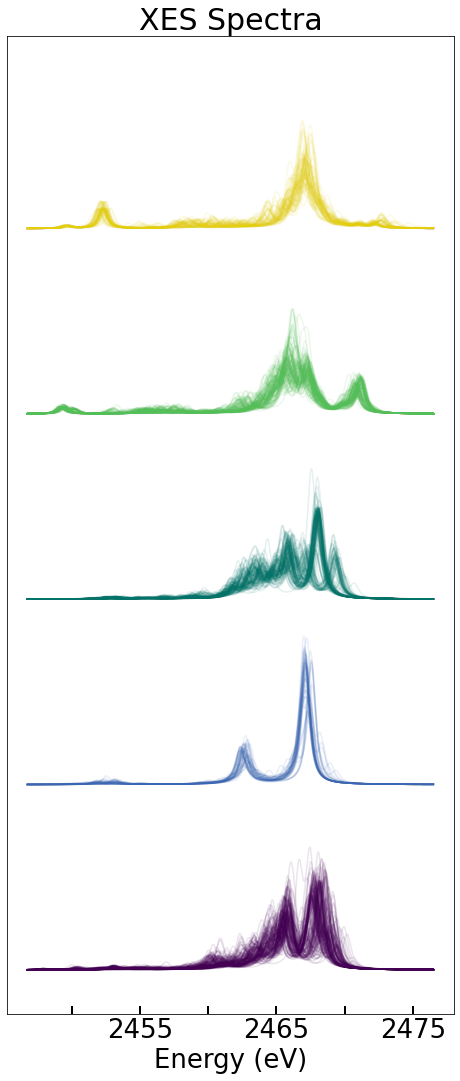

In [17]:
Spagetti_plot(Data)

# Data analysis

### Type Number vs Transition Integral:

In [18]:
# plot_Type_vs_Transition_Sum(Data)

In [19]:
# create_transition_v_type_hist(Data, n_bins=18)

In [20]:
# create_transition_v_type_hist(Data, chosen_type=1, show_conj=True) # showing conjugated
# create_transition_v_type_hist(Data, chosen_type=1) # everything

In [21]:
# # create_transition_v_type_hist(Data, chosen_type=2, max_range=0.005)
# create_transition_v_type_hist(Data, chosen_type=2, show_conj=True) # showing conjugated
# create_transition_v_type_hist(Data, chosen_type=2) # everything

In [22]:
# create_transition_v_type_hist(Data, chosen_type=3, show_conj=True) # showing conjugated
# create_transition_v_type_hist(Data, chosen_type=3) # everything

C:\Users\saman\Downloads\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


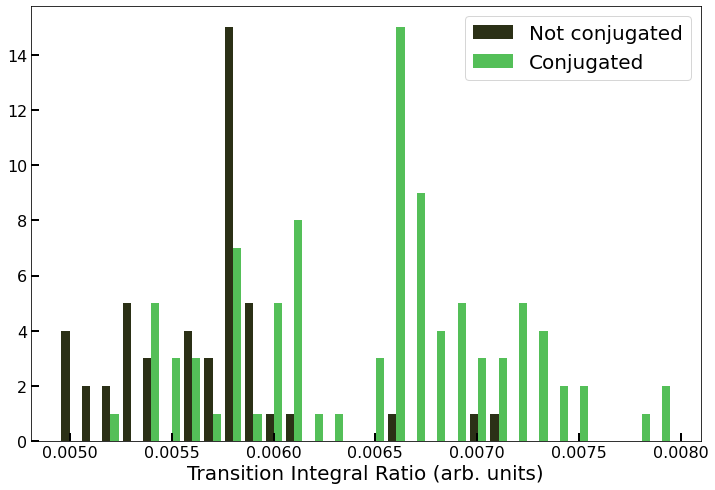

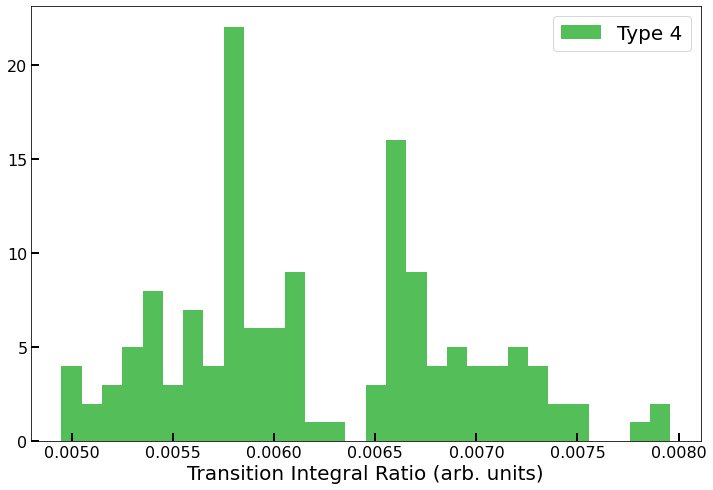

In [23]:
create_transition_v_type_hist(Data, chosen_type=4, show_conj=True) # showing conjugated
create_transition_v_type_hist(Data, chosen_type=4) # everything

In [24]:
# create_transition_v_type_hist(Data, chosen_type=5, show_conj=True) # showing conjugated
# create_transition_v_type_hist(Data, chosen_type=5) # everything

=========================================================================================================================

# Artificial Neural Network Section

### Network hyperparameters

In [25]:
# hidden layer dimensions
intermediate_dim_1 = 512

batch_size = 50
epochs = 50

train_size = 700

### Generating Labels

In [26]:
# PROPERTY = 'Type'
PROPERTY = 'oxy'
# PROPERTY = 'category'

In [27]:
X = X.copy()
Y = get_Property(Data, PROPERTY) # labels are one hot encoded

## Data pre-processing and shuffling

In [28]:
# # random shuffle of data
index_shuffle = np.arange(len(Data))
random.shuffle(index_shuffle)

In [29]:
Xshuffle = []
Yshuffle = []
for index in index_shuffle:
    Xshuffle.append(X[index])
    Yshuffle.append(Y[index])
Xshuffle = np.array(Xshuffle)
Yshuffle = np.array(Yshuffle)

#### Dividing data into training set, validation set, and test set

In [30]:
x_train = Xshuffle[:train_size]
y_train = Yshuffle[:train_size]

x_test = Xshuffle[train_size:]
y_test = Yshuffle[train_size:]

n_y = y_train.shape[1]
n_x = x_train.shape[1]

# Generating ANN Model

In [31]:
# # creating model
# # input
# Xin = Input(shape=(n_x,), name='spectra_input')
# # model layers
# lay = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(Xin)
# lay = Dropout(0.05)(lay)
# nn_out = Dense(n_y, activation='softmax', name='classifier')(lay)

# ANN = Model(Xin, nn_out)

# # creating loss
# # loss = n_y * binary_crossentropy(label, nn_out)
# # ANN.add_loss(loss)

# ANN.compile(optimizer='adam', loss='binary_crossentropy')
# ANN.summary()

### Training

In [32]:
# ANN.fit(x_train, y_train, 
#          shuffle=True, batch_size=batch_size, epochs=epochs,
#          validation_data=(x_test, y_test))
# ANN.save(f'models/XES_ANN_{PROPERTY}.h5')

In [33]:
# PROPERTY = 'Type'
PROPERTY = 'oxy'
# PROPERTY = 'category'
ANN = load_model(f'models/XES_ANN_{PROPERTY}.h5', compile=False)

# Prediction Results

In [34]:
if PROPERTY == 'oxy':
    one_hot_encoded_label = np.zeros((len(TEST_XES), 3))
    for i,o in enumerate(TEST_OXY):
        one_hot_encoded_label[i,o-1] = 1
    true, pred = get_prediction(ANN, TEST_XES, one_hot_encoded_label)
if PROPERTY == 'Type':
    one_hot_encoded_label = np.zeros((len(TEST_XES), 5))
    for i,t in enumerate(TEST_TYPE):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XES, one_hot_encoded_label)
if PROPERTY == 'category':
    one_hot_encoded_label = np.zeros((len(TEST_XES), 10))
    for i,t in enumerate(TEST_CAT):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XES, one_hot_encoded_label)

In [35]:
totalTestAccuracy = sum(1 for i in range(len(pred)) if pred[i] == true[i])/len(pred)
print(f"Total accuracy on test data: {totalTestAccuracy} of {len(pred)} compounds")

Total accuracy on test data: 1.0 of 52 compounds


### Confusion Matrix

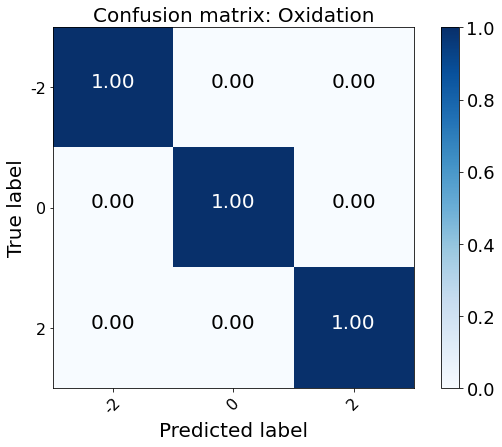

In [36]:
if PROPERTY == 'Type':    
    make_confusion_matrix(true, pred, Types, PROPERTY, cmap=plt.cm.Blues)
if PROPERTY == 'oxy':
    make_confusion_matrix(true, pred, Oxys, PROPERTY, cmap=plt.cm.Blues)
if PROPERTY == 'category':
    make_confusion_matrix(true, pred, Categories, PROPERTY, cmap=plt.cm.Blues)

=========================================================================================================================

# VAE Categorization

In [37]:
# hidden layer dimensions
intermediate_dim_1 = 512
intermediate_dim_2 = 128#246
latent_dim = 2

epochs = 120

dropout = 0.1

In [38]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [39]:
# input
Xin = Input(shape=(n_x,), name='spectra_input')

# encoder
x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(Xin)
x = Dropout(dropout)(x)
x = Dense(intermediate_dim_2, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(dropout)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean_val, z_log_var_val = args
    batch = K.shape(z_mean_val)[0]
    dim = K.int_shape(z_mean_val)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean_val + K.exp(0.5 * z_log_var_val) * epsilon

# z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z = Sampling()([z_mean, z_log_var])

# encoder
encoder = Model(Xin, [z_mean, z_log_var, z], name='encoder')

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim_2, activation='relu', kernel_regularizer='l2')(latent_inputs)
x = Dropout(dropout)(x)
x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(latent_inputs)
x = Dropout(dropout)(x)
outputs = Dense(n_x, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
 
# VAE
Output = decoder(encoder(Xin)[2])
vae = Model(Xin, Output, name='VAE')

reconstruction_loss = n_x * binary_crossentropy(Xin, Output)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
history = vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

vae.save('models/XES_VAE', save_format="tf")
encoder.save('models/XES_encoder', save_format="tf")
decoder.save('models/XES_decoder', save_format="tf")

Epoch 1/120
14/14 [==============================] - 2s 74ms/step - loss: 642.4133 - val_loss: 321.6327
Epoch 2/120
14/14 [==============================] - 0s 22ms/step - loss: 255.1209 - val_loss: 161.2560
Epoch 3/120
14/14 [==============================] - 0s 24ms/step - loss: 158.5646 - val_loss: 145.6140
Epoch 4/120
14/14 [==============================] - 0s 23ms/step - loss: 145.9291 - val_loss: 139.2862
Epoch 5/120
14/14 [==============================] - 0s 31ms/step - loss: 141.0998 - val_loss: 135.4754
Epoch 6/120
14/14 [==============================] - 0s 23ms/step - loss: 137.3784 - val_loss: 134.5318
Epoch 7/120
14/14 [==============================] - 0s 22ms/step - loss: 136.0480 - val_loss: 132.9458
Epoch 8/120
14/14 [==============================] - 0s 22ms/step - loss: 134.5114 - val_loss: 131.4237
Epoch 9/120
14/14 [==============================] - 0s 23ms/step - loss: 133.7801 - val_loss: 130.3609
Epoch 10/120
14/14 [==============================] - 0s 23ms/st

14/14 [==============================] - 0s 33ms/step - loss: 120.6612 - val_loss: 118.9708
Epoch 80/120
14/14 [==============================] - 0s 31ms/step - loss: 120.4367 - val_loss: 119.0666
Epoch 81/120
14/14 [==============================] - 0s 34ms/step - loss: 120.7568 - val_loss: 118.7365
Epoch 82/120
14/14 [==============================] - 0s 33ms/step - loss: 121.0725 - val_loss: 118.8039
Epoch 83/120
14/14 [==============================] - 0s 31ms/step - loss: 120.5681 - val_loss: 119.0795
Epoch 84/120
14/14 [==============================] - 0s 30ms/step - loss: 120.8189 - val_loss: 119.2381
Epoch 85/120
14/14 [==============================] - 0s 31ms/step - loss: 120.1989 - val_loss: 118.6287
Epoch 86/120
14/14 [==============================] - 0s 31ms/step - loss: 120.0927 - val_loss: 119.0947
Epoch 87/120
14/14 [==============================] - 0s 28ms/step - loss: 120.3099 - val_loss: 118.9279
Epoch 88/120
14/14 [==============================] - 0s 27ms/step -

In [40]:
# vae = load_model('models/XES_VAE', compile=False)
# encoder = load_model('models/XES_encoder', compile=False)
# decoder = load_model('models/XES_decoder', compile=False)
# vae.summary()

In [41]:
# can only do this when training, not loading
# show_loss(history, 'XES')

In [42]:
# these were copy and pasterd in to XANESML for the comparison plot
# print(history.history['loss'])

In [43]:
Is = [0, 200, 300, 450, 700]
x_decode = np.array([X[i] for i in Is])
decode_names = np.array([NAMES[i] for i in Is])
print(decode_names)

['1,3-Thiazol-4-ylacetic_acid' 'Protionamide' '4-dimethylamino-thiophenol'
 'Dl-Ethionine_sulfoxide' 'Tetrachlorothiophene-sulfone']


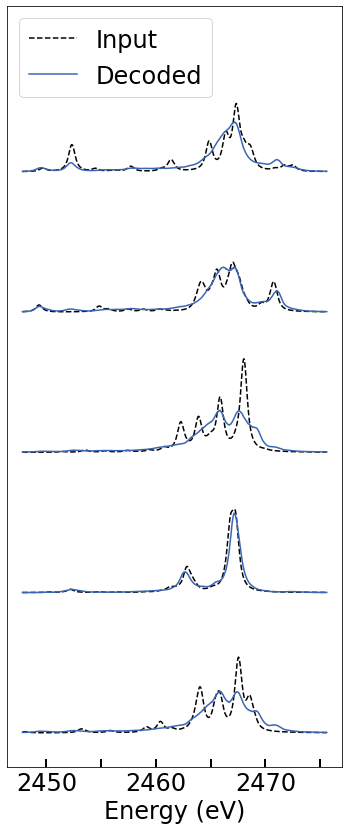

In [44]:
plot_in_v_out(XESenergy, vae, x_decode, decode_names, figsize=(6,14), c=1, x_range=(80,-125), method='XES')

In [45]:
def make_network_plot(Data, encoder):
    X_Types = []
    for t in Types:
        names = get_Property(get_type_eles(Data, t), 'name')
        X_temp = []
        for name in names:
            X_temp.append(get_x(name))
        random.shuffle(X_temp)
        X_Types.append(X_temp)

    percents = np.linspace(0,1,6)

    x_list = []

    sample_size = [20, 10, 20, 20, 20]

    random_start = np.zeros(5)
    for i in Types:
        max_ind = len(X_Types[i-1]) - sample_size[i-1] - 1
        random_start[i-1] = randint(0, max_ind)    
    # print(random_start)

    for i in range(5):
        start_i = int(random_start[i])
        sample_i = sample_size[i]
        for x1 in X_Types[i][start_i : start_i + sample_i]:
            j = i + 1
            if i == j:
                break
            while j < 5:
                start_j = int(random_start[j])
                sample_j = sample_size[j]
                for x2 in X_Types[j][start_j : start_j + sample_j]:
                    x_list.append(np.array([x1*percent + x2*(1-percent) for percent in percents]))
                j += 1

    print(f'Total combinations: {len(x_list)}')       
    network_plot("", x_list, encoder)

In [46]:
def get_x(name):
    x = get_Spectrum(Data, name)[1]
    x = x/SCALING_FACTOR
    return x

In [47]:
def network_plot(title, x_predict_list, encoder):
    
    z_means = []
    for x in x_predict_list:
        z_mean = encoder.predict(x, batch_size=100)[0]
        z_means.append(z_mean)
    
    z_meanX = encoder.predict(X, batch_size=batch_size)[0]
    Y = one_hot_to_num(get_Property(Data, 'oxy'))
    
    fontsize=28
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
        
    Colors = [COLORS[0], COLORS[2], COLORS[4]]
    cmap = ListedColormap(Colors)
    plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c=Y*2-4, cmap=cmap)
    
    alpha, color, ms = 0.01, 'k', 2
    
    for z_mean in z_means:
        plt.plot(z_mean[:, 0], z_mean[:, 1], '-', c=color, alpha=alpha, markersize=ms)

    loc = [-1.33, 0, 1.33]
    cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
    cbar = plt.colorbar(cax=cbaxes, ticks=Oxys)
    cbar.set_label('Oxidation', fontsize=26)
    cbar.set_ticks(loc)
    cbar.ax.tick_params(labelsize=22)
    cbar.set_ticklabels(Oxys)    
#     legend = ax.legend(['VAE'], handlelength=0, handletextpad=0, fancybox=True, fontsize=fontsize+8)
#     for item in legend.legendHandles:
#         item.set_visible(False)
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
    ax.set_xlabel(f"z [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"z [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

In [48]:
# make_network_plot(Data, encoder)

In [49]:
def plot(PROPERTY, x_predict, y_predict, encoder, X,test_index=None,
         extra_name=None, save=False, focus=None, a=.3, s=5, leg=3, black=False):
     
    z_mean = encoder.predict(x_predict, batch_size=1)[0]
    
    fontsize=28
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
#     fig, ax = plt.subplots(figsize=(12, 8))
    
    cbar_vis = True
    
    if PROPERTY == 'oxy':
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict)*2-4, cmap=cmap)
        ticks = Oxys
        title = 'Oxidation'
        loc = [-1.33, 0, 1.33]
        label = title
        
    elif PROPERTY == 'category':
        Colors = list(COLORMAP(np.arange(1,11)/9))
        title = "Category"
        label = title
        
        if focus is not None:
            
            for i in range(10):
                Colors[i] = (128/255,128/255,128/255,0.2)
            
            # type 1
            Colors[0] = COLORS[0].copy()
            Colors[1] = '#9F5F80'
            # type 2
            Colors[2] = '#03506F'
            Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
            # type 3
            Colors[4] = '#DB6400' #'#ac3501'
            Colors[5] = '#ffba93' #'#f89345'
            # type 4
            Colors[6] = '#2b3016'
            Colors[7] = COLORS[3].copy()
            # type 5
            Colors[8] = '#ac3501'
            Colors[9] = COLORS[4]
            
            title = 'Conjugated vs Not Conjugated'
            
            t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
            t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
            t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
            t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
            t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
            t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
            t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
            t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
            t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
            t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
            space = mpatches.Patch(color='w', label='')
            
            fig.subplots_adjust(right=0.75)
            
#             plt.legend(handles=[t1a, t1b, space, t2a, t2b, space, t3a, t3b, space, t4a, t4b, space, t5a, t5b],
#                     fontsize=18, bbox_to_anchor=(1.02, 0.97), loc=leg, borderaxespad=0.)
            plt.legend(handles=[t1a, t1b, t2a, t2b, t3a, t3b, t4a, t4b, t5a, t5b], ncol=5,
                fontsize=18, bbox_to_anchor=(0., 1.13, 1., 0.025), loc=leg, borderaxespad=0.)
            cbar_vis = False
            
        
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        
        if cbar_vis:
            cbar = plt.colorbar(ticks=np.arange(10)+1)

        
    elif PROPERTY == 'Type':
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        ticks = Types
        title = "Type"
        label = title
        loc = [1.4, 2.2, 3, 3.8, 4.6]
        if test_index is not None:
            ztest = encoder.predict(TEST_XES)[0]
            if test_index is 'all':
                plt.scatter(ztest[:, 0], ztest[:, 1], c='r', s=35)
            else:
                plt.plot(ztest[test_index, 0], ztest[test_index, 1], 'r.', markersize=15)
        
    else:
        
        z_meanX = encoder.predict(X, batch_size=batch_size)[0]
        Y = one_hot_to_num(get_Property(Data, 'oxy'))
        
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c=Y*2-4, cmap=cmap)
        if z_mean.shape[0] > 5:
            alpha, color, ms = a, 'k', s
            plt.plot(z_mean[:, 0], z_mean[:, 1], '.-', c=color, alpha=alpha, markersize=ms)
        else:
#             color = COLORS[1].copy() + (60/255,75/255,75/255,0.)
            alpha, ms = a, s
            for i,pt in enumerate(z_mean):
                if i in [2,3]:
                    c='k'
                else:
                    c='#eb5600'
                plt.plot(z_mean[i, 0], z_mean[i, 1], 'o', c=c, alpha=1, markersize=ms+5, fillstyle='none')
                plt.plot(z_mean[i, 0], z_mean[i, 1], 'o', c=c, alpha=1, markersize=ms+3, fillstyle='none')
                plt.plot(z_mean[i, 0], z_mean[i, 1], 'o', c=c, alpha=1, markersize=ms+1, fillstyle='none')
            extra_name = None
        title = PROPERTY
        label = 'Oxidation'
        ticks = Oxys
        loc = [-1.33, 0, 1.33]
        if extra_name is not None:
            x = np.array([get_x(extra_name)])
            extra_name = extra_name.lower().replace('_' , ' ')
            z_loc = encoder.predict(x, batch_size=1)[0]
            plt.plot(z_loc[:, 0], z_loc[:, 1], '.', c='r', alpha=1., markersize=15, label=extra_name)
            plt.legend(fontsize=20)
    
    if black:
        z_meanX = encoder.predict(X, batch_size=batch_size)[0]
        Y = one_hot_to_num(get_Property(Data, 'oxy'))
        plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c='k')
        cbar_vis=False
    
    if cbar_vis:
        cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
        cbar = plt.colorbar(cax=cbaxes, ticks=ticks)
        cbar.set_label(label, fontsize=26)
        cbar.set_ticks(loc)
        cbar.ax.tick_params(labelsize=26)
        cbar.set_ticklabels(ticks)
        if extra_name is None:
            legend = ax.legend(['VAE'], markerscale=0.01, handlelength=0, handletextpad=0,
                               fancybox=True, fontsize=fontsize+12)
            for item in legend.legendHandles:
                item.set_visible(False)
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
#     plt.title(f"Latent Space: {title}", fontsize=fontsize+8)
    ax.set_xlabel(f"z [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"z [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()
    if save:
        fig.savefig(f'{title}.png', bbox='tight')

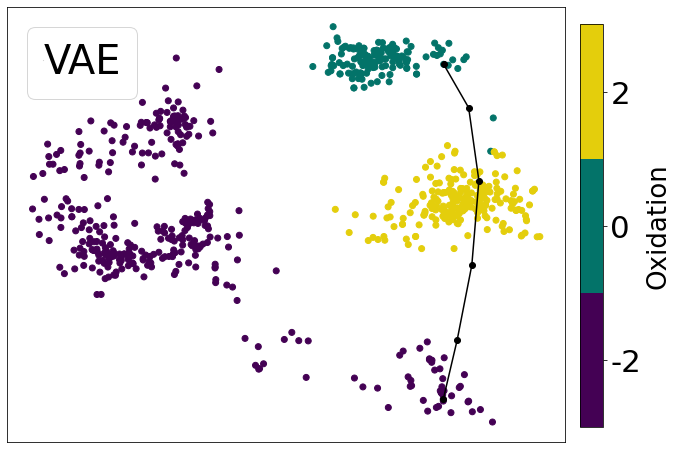

In [50]:
# extra_name = 'Methanesulfonylacetone'
MIN, MAX = 50, 950
extra_name = 'Zonisamide'
name1 = "Goitrin"
x1 = get_x(name1)
name2 = "Thiophene_oxide"
x2 = get_x(name2)
name1, name2 = "goitrin", "thiophene oxide"
percents = np.linspace(0,1,6)
lin_combos = np.array([x1*percent + x2*(1-percent) for percent in percents])
plot(f"Linear Combination Data\n{name1} to {name2} by 20% steps", lin_combos, percents,
     encoder, X, a=1., s=12)
# plot(f"Linear Combination Data\n{name1} to {name2} by 20% steps", lin_combos, percents,
#      encoder, X, a=1., s=12, extra_name=extra_name)

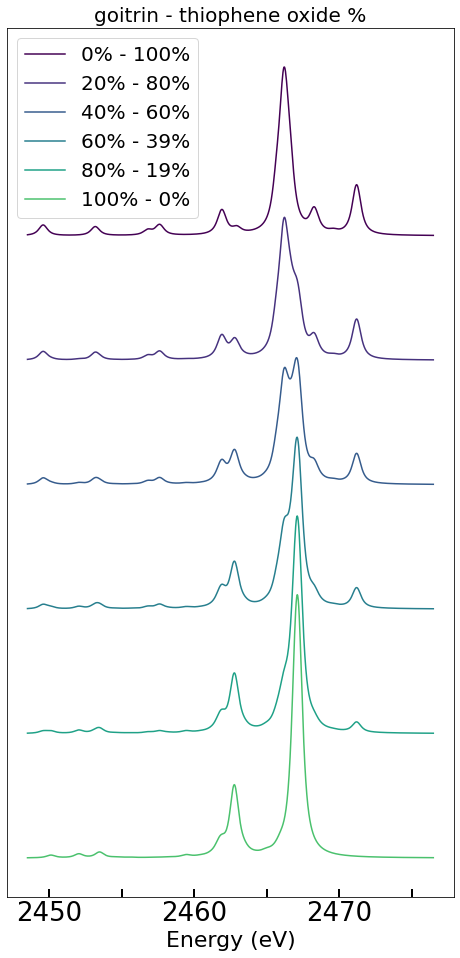

In [51]:
MIN, MAX = 100, 900
names = [f"{int(x*100)}% - {int((1-x)*100)}%" for x in percents]
temp = []
for e in lin_combos:
    temp.append( e[MIN:MAX] )
stack_plot(XESenergy[MIN:MAX], temp, names, f'goitrin - thiophene oxide %', space=0.4, figsize=(8,16),
          fontsize=18, method='XES')

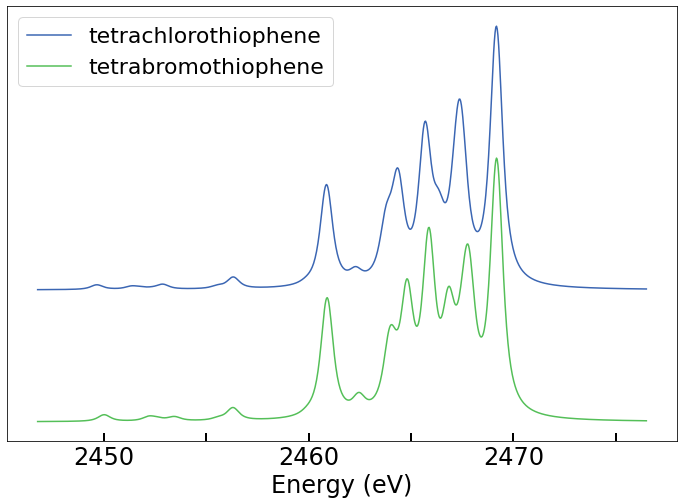

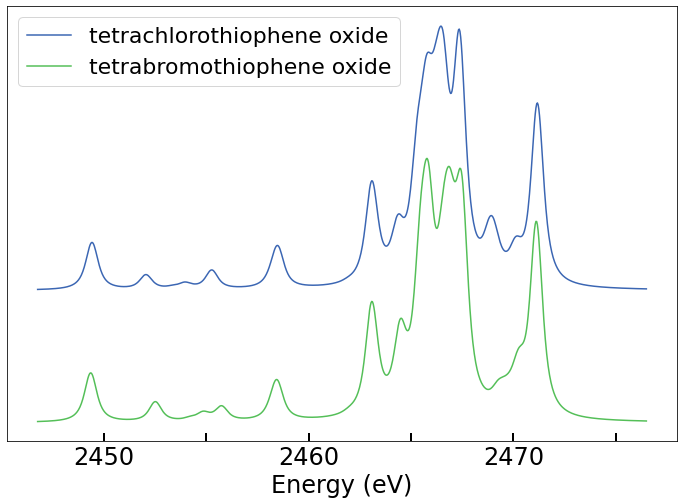

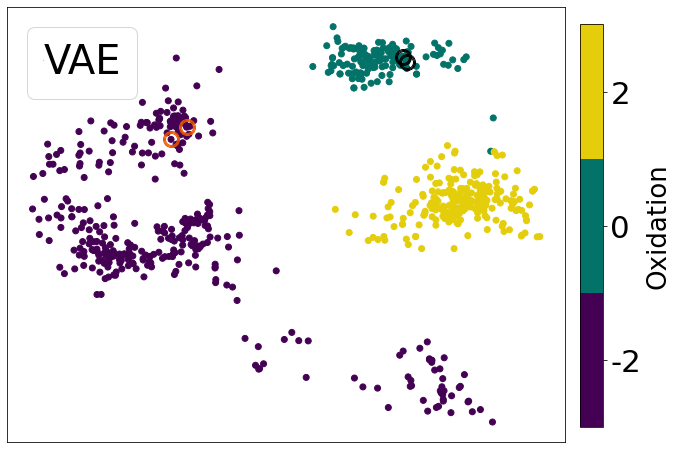

In [52]:
MIN, MAX = 50, 900

name1, name2 = 'Tetrabromothiophene', 'Tetrachlorothiophene'
x1, x2 =  get_x(name1), get_x(name2)
name1, name2 = 'tetrabromothiophene', 'tetrachlorothiophene'
plot_stacked_spectrum(XESenergy[MIN:MAX], x1[MIN:MAX], x2[MIN:MAX], name1, name2,
                      space=0.5, title='', method='XES', loc=2)

name3, name4 = 'Tetrabromothiophene_oxide', 'Tetrachlorothiophene_oxide'
x3, x4 =  get_x(name3), get_x(name4)
name3, name4 = 'tetrabromothiophene oxide', 'tetrachlorothiophene oxide'

plot_stacked_spectrum(XESenergy[MIN:MAX], x3[MIN:MAX], x4[MIN:MAX], name3, name4,
                      title='', space=0.5, method='XES', loc=2)

plot(f"XES", np.array([x1, x2, x3, x4]), [], encoder, X, a=1., s=11)

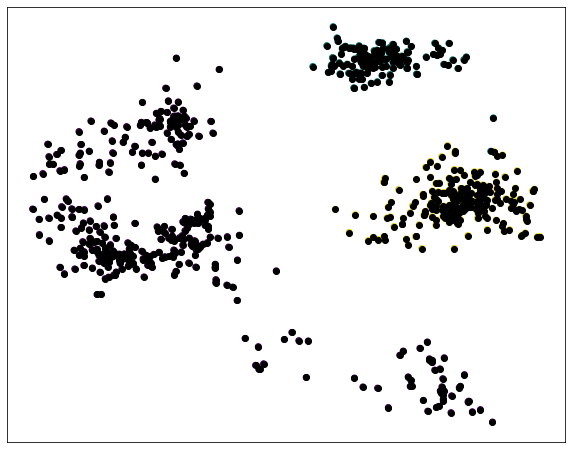

In [53]:
plot(PROPERTIES[0], X, Labels[0], encoder, X, black=True)

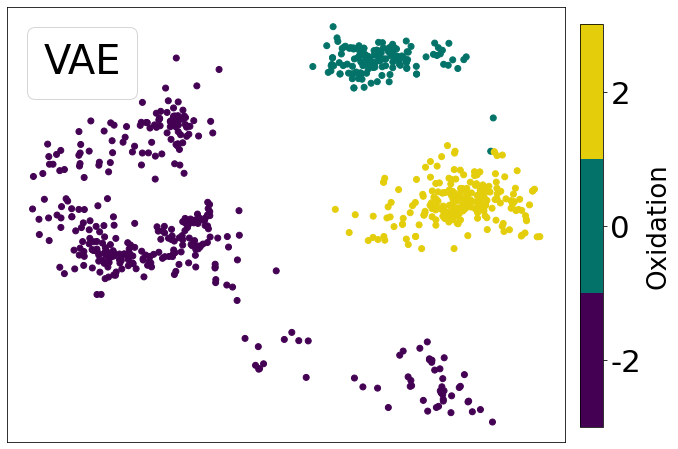

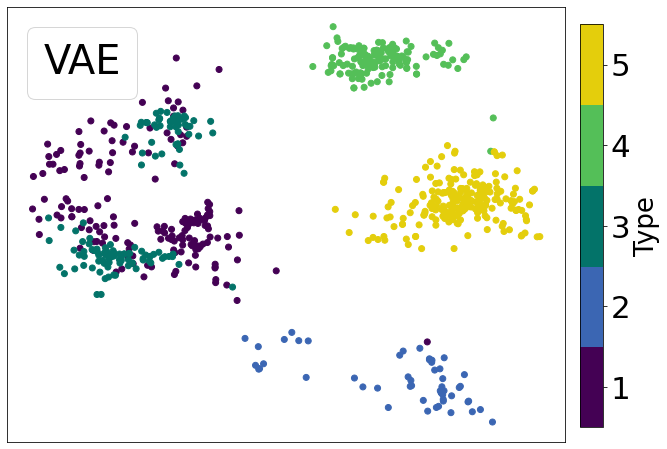

In [54]:
for PROPERTY in PROPERTIES[:2]:
    plot(PROPERTY, X, Labels[PROPERTIES.index(PROPERTY)], encoder, X)

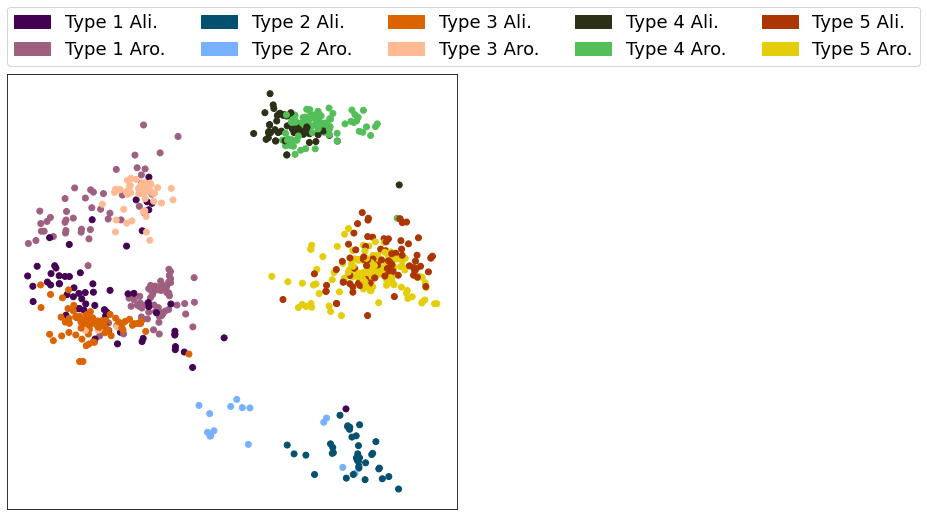

In [55]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot('category', X, Labels[2], encoder, X, focus=1, leg=2)

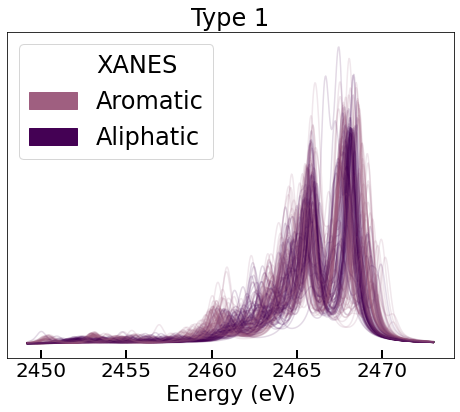

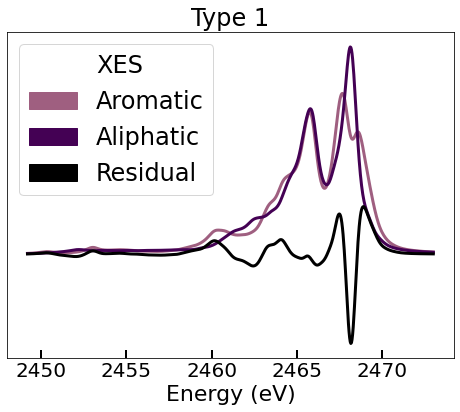

In [56]:
type_spagetti(XESenergy, NAMES, Data, 'XES', X, Type=1, space=0., figsize=(8,6), alpha=0.15) 

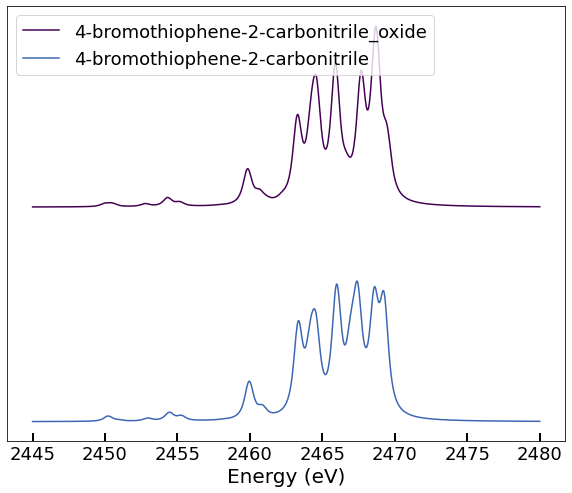

In [57]:
name1, name2 = '4-bromothiophene-2-carbonitrile_oxide', '4-bromothiophene-2-carbonitrile'
x1, x2 =  get_x(name1), get_x(name2)
stack_plot(XESenergy, [x1, x2], [name1, name2], title=f'', space=0.4, figsize=(10,8))

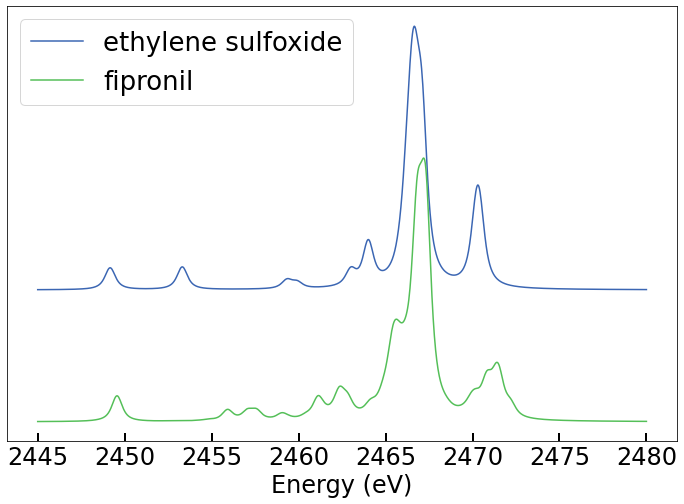

In [58]:
name1, name2 = 'Fipronil', 'Ethylene_sulfoxide'
x1, x2 =  get_x(name1), get_x(name2)
name1, name2 = 'fipronil', 'ethylene sulfoxide'
plot_stacked_spectrum(XESenergy, x1, x2, name1, name2, title=f'', space=0.5)

# K means

In [59]:
def plot_centroids(x_predict, y_predict, codebook):
    
    z_mean = encoder.predict(x_predict, batch_size=batch_size)[0]
    
    fontsize=16
    fig, ax = plt.subplots(figsize=(12, 8))
    if PROPERTY == 'oxy':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict)*2-4, cmap=COLORMAP)
        plt.colorbar(ticks=Oxys)
        plt.title("Latent Space vs Sulfur Oxidation", fontsize=fontsize+4)
    elif PROPERTY == 'category':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=COLORMAP)
        plt.colorbar()
        plt.title("Latent Space vs Category", fontsize=fontsize+4)
    else:
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        cbar = plt.colorbar(ticks=Types)
#         plt.title("Latent Space vs Type", fontsize=fontsize+4)
    
    plt.plot(codebook[:, 0], codebook[:, 1], '.', c='r', markersize=20)
    
    cbar.set_label(PROPERTY, fontsize=26)
    cbar.ax.tick_params(labelsize=22)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

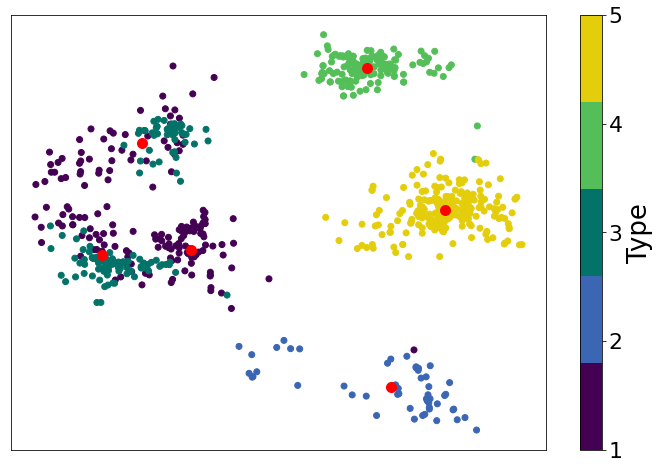

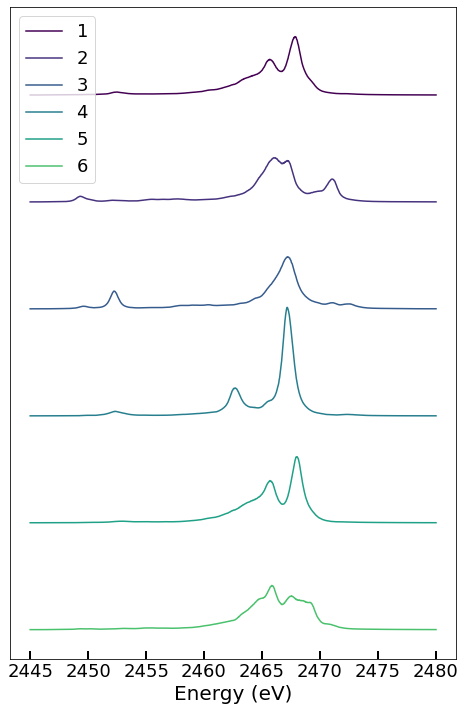

In [60]:
PROPERTY = 'Type'
codebook, distortion = kmeans(encoder.predict(X)[0], 6)
plot_centroids(X, Labels[PROPERTIES.index(PROPERTY)], codebook)
Spectra = decoder.predict(codebook)
stack_plot(XESenergy, Spectra, np.arange(len(codebook))+1, title=f'', space=0.6, figsize=(8,12))

# First Half VAE

In [61]:
# size = 400

# xtrain = x_train[:,:size]
# for i in range(train_size):
#     xtrain[i] = xtrain[i]/np.max(xtrain[i])

# xtest = x_test[:,:size]
# for i in range(len(xtest)):
#     xtest[i] = xtest[i]/np.max(xtest[i])

In [62]:
# n_x = size

# # input
# Xin = Input(shape=(n_x,), name='spectra_input')

# # encoder
# x = Dense(intermediate_dim_1, activation='relu')(Xin)
# x = Dropout(dropout)(x)
# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# # encoder
# encoder2 = Model(Xin, [z_mean, z_log_var, z], name='encoder')

# # decoder
# latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim_1, activation='relu')(latent_inputs)
# x = Dropout(dropout)(x)
# outputs = Dense(n_x, activation='sigmoid')(x)

# decoder = Model(latent_inputs, outputs, name='decoder')

# # VAE
# Output = decoder(encoder2(Xin)[2])
# vae_half = Model(Xin, Output, name='VAE')

# reconstruction_loss = n_x * binary_crossentropy(Xin, Output)
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
# vae_loss = K.mean(reconstruction_loss + kl_loss)

# vae_half.add_loss(vae_loss)
# optimizer = adam(lr=0.0050, decay=0.0005)
# vae_half.compile(optimizer=optimizer)

In [63]:
# vae_half.fit(xtrain,
#         epochs=10,
#         batch_size=batch_size,
#         validation_data=(xtest, None))

In [64]:
# x = X[:,:size].copy()
# x = x/np.max(x)

# for PROPERTY in PROPERTIES:
#     plot(PROPERTY, x, Labels[PROPERTIES.index(PROPERTY)], encoder2, x)

In [65]:
# Spagetti_plot(Data, size=size)

# One Type VAE

In [66]:
# # 'Aliphatic', 'Aromatic'
# myType = 4
# x_one = []
# y_one = []
# for ele in Data:
#     if ele['Type'] == myType:
#         x = ele['XES'][1]
#         x = x - np.min(x)
#         x = x/np.max(x)
#         x_one.append(x)
#         if myType in [1,3,4]:
#             y = ele['conj']
#             if y == -1:
#                 print(ele['name'])
#         else:
#             y = 0
#         y_one.append(y)

# x_one = np.array(x_one)
# y_one = np.array(y_one)
# # y_one = np.array([y_one]).T

In [67]:
# n_x = 1000
# intermediate_dim_1 = 256

# # input
# Xin = Input(shape=(n_x,), name='spectra_input')

# # encoder
# x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(Xin)
# x = Dropout(0.01)(x)
# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# # encoder
# encoder3 = Model(Xin, [z_mean, z_log_var, z], name='encoder')

# # decoder
# latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(latent_inputs)
# x = Dropout(0.01)(x)
# outputs = Dense(n_x, activation='sigmoid')(x)

# decoder = Model(latent_inputs, outputs, name='decoder')

# # VAE
# Output = decoder(encoder3(Xin)[2])
# vae2 = Model(Xin, Output, name='VAE')

# reconstruction_loss = n_x * binary_crossentropy(Xin, Output)
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
# vae_loss = K.mean(reconstruction_loss + kl_loss)

# vae2.add_loss(vae_loss)
# vae2.compile(optimizer='adam')

In [68]:
# training_size = [150, 45, 120, 130, 210]
# type_size = training_size[myType-1]
# type_size = 345
# vae2.fit(x_one[:type_size],
#         epochs=45,
#         batch_size=30,
#         validation_data=(x_one[type_size:], None))

In [69]:
# plot(myType, x_one, y_one, encoder3, x_one)
# plot('all', x_one, y_one, encoder3, x_one)

# PCA

In [70]:
def plot_dim_red(PROPERTY, X_red, Y, method, pt=None, leg=2, cbar_vis=True, fontsize=28, show_legend=True):
    
    Colors = list(COLORMAP(np.arange(1,11)/9))
    for i in range(10):
        Colors[i] = (128/255,128/255,128/255,0.2)
            
    # type 1
    Colors[0] = COLORS[0].copy()
    Colors[1] = '#9F5F80'
    # type 2
    Colors[2] = '#03506F'
    Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
    # type 3
    Colors[4] = '#DB6400' #'#ac3501'
    Colors[5] = '#ffba93' #'#f89345'
    # type 4
    Colors[6] = '#2b3016' 
    Colors[7] = COLORS[3].copy()
    # type 5
    Colors[8] = '#ac3501'
    Colors[9] = COLORS[4]

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
#     fig, ax = plt.subplots(figsize=(12, 8))
    
    if PROPERTY == 'oxy':
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=one_hot_to_num(Y)*2-4, cmap=cmap)
        ticks=Oxys
        title = 'Oxidation'
        loc = [-1.33, 0, 1.33]
        label = title
        
    elif PROPERTY == 'category':
        
        title = "Category"
        label = title
            
        title = 'Conjugated vs Not Conjugated'
            
        t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
        t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
        t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
        t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
        t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
        t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
        t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
        t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
        t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
        t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
        space = mpatches.Patch(color='w', label='')
            
        fig.subplots_adjust(right=0.75)
            
#         plt.legend(handles=[t1a, t1b, space, t2a, t2b, space, t3a, t3b, space, t4a, t4b, space, t5a, t5b],
#             fontsize=14, bbox_to_anchor=(1.02, 0.97), loc=leg, borderaxespad=0.)
        if show_legend:
            plt.legend(handles=[t1a, t1b, t2a, t2b, t3a, t3b, t4a, t4b, t5a, t5b], ncol=5,
                fontsize=18, bbox_to_anchor=(0., 1.13, 1., 0.025), loc=leg, borderaxespad=0.)
            
        cbar_vis = False
        
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=one_hot_to_num(Y), cmap=cmap)
        
    elif PROPERTY == 'Type':
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=one_hot_to_num(Y), cmap=cmap)
        ticks=Types
        title = "Type"
        loc = [1.4, 2.2, 3, 3.8, 4.6]
        label = title
        
    elif PROPERTY in Types: 
        base = 2*PROPERTY - 2
        subColors = [Colors[base], Colors[base+1]]
        cmap = ListedColormap(subColors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap)
        ticks=[0,1]
        ticks=['Ali.','Aro.']
        title = f"Type {PROPERTY}"
        loc = [0.25,0.75]
        label = title
    
    if pt is not None:
        plt.scatter(pt[0], pt[1], c='r')
    
    
    if cbar_vis:
        cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
        cbar = plt.colorbar(cax=cbaxes, ticks=ticks)
        cbar.set_label(label, fontsize=26)
        cbar.set_ticks(loc)
        cbar.ax.tick_params(labelsize=22)
        cbar.set_ticklabels(ticks)
        legend = ax.legend([method], handlelength=0, handletextpad=0, fancybox=True, fontsize=fontsize+12)
        for item in legend.legendHandles:
            item.set_visible(False)
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
#     plt.title(f"{method}", fontsize=fontsize+12)
    ax.set_xlabel(f"{method} [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"{method} [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

In [71]:
pca = PCA(n_components=2)
pca.fit(X)
X_PCA = pca.transform(X)

In [72]:
X_PCA.shape

(717, 2)

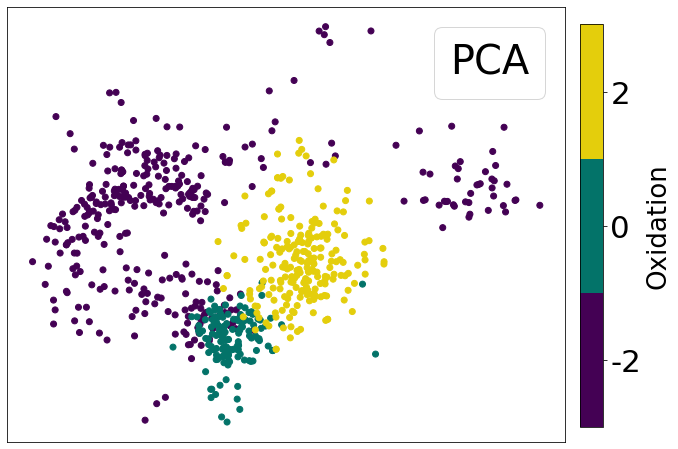

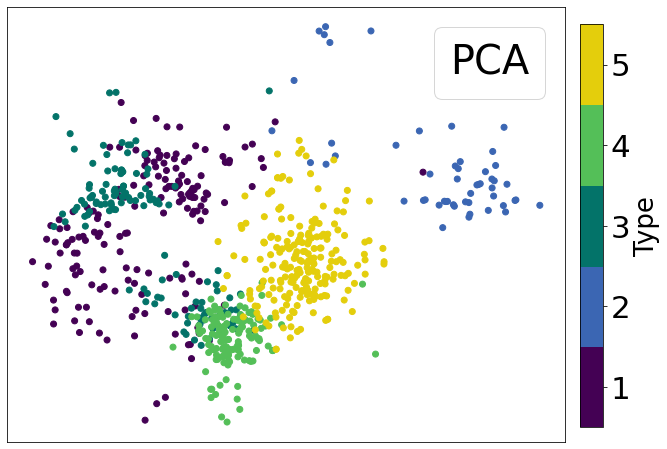

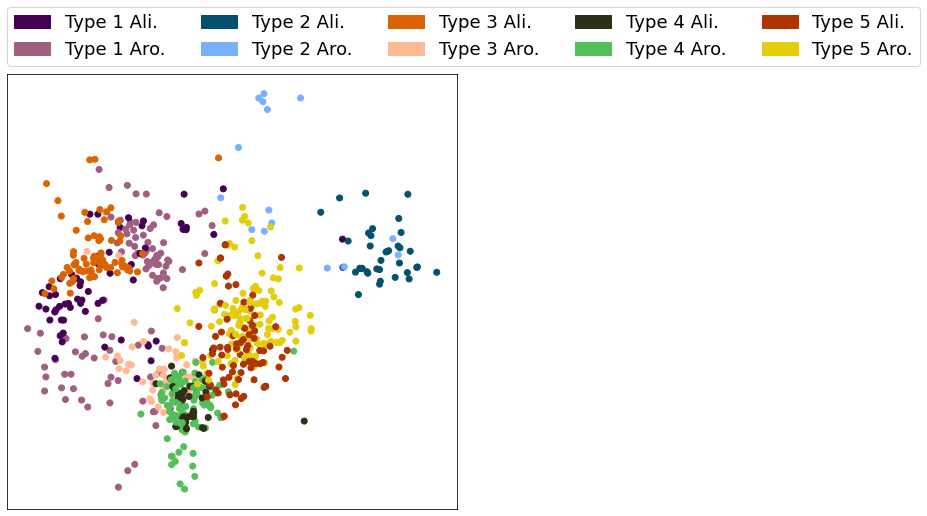

In [73]:
for PROPERTY in PROPERTIES:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plot_dim_red(PROPERTY, X_PCA, Labels[PROPERTIES.index(PROPERTY)],'PCA')

# PCA without specifying dimension

In [74]:
def make_scree(evals, n):

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(n)+1
    N = evals.shape[0]
    colors = COLORMAP(np.arange(N)/N)

    avg = np.zeros(n)
    for i in range(N):
        y = evals[i]
        y = y/np.sum(y)
#         if i%100 is 0:
#             ax.plot(x, y, markersize=1, color=colors[i])
        avg += y
    
    avg = avg/float(N)
    ax.plot(x, avg, markersize=1, color='k', label='Average')

#     plt.title("Scree Plot: XES", fontsize=20)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Number of Parameters', fontsize=20)
    plt.ylabel(f'Contribution', fontsize=16)

    plt.show()
    
    return avg

In [75]:
# pca = PCA(n_components = 0.9, svd_solver = 'full')
pca = PCA()
pca.fit(X)
X_PCA = pca.transform(X)
X_PCA.shape

(717, 717)

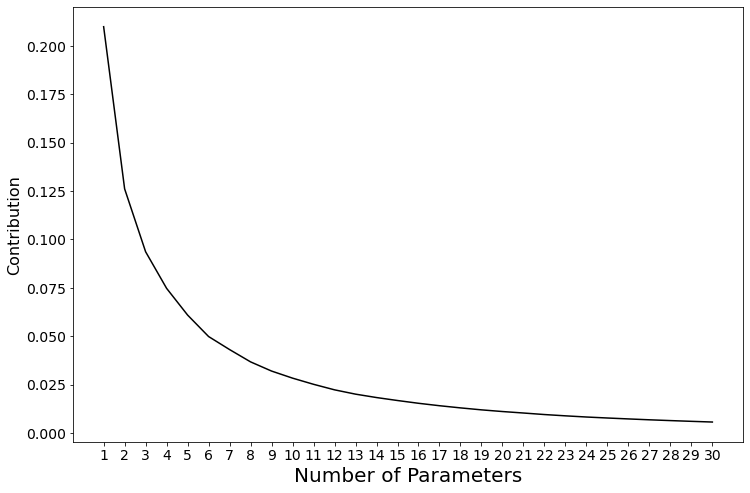

In [76]:
n = 30
evals = np.sort(np.abs(X_PCA), axis=1)
evals = np.flip(evals, axis=1)[:,:n]
xes_pc = make_scree(evals, n)

In [77]:
temp = []
for i in range(n):
    temp.append(f'{xes_pc[i]:.7f}')
temp = np.array(temp)
temp

array(['0.2099057', '0.1261262', '0.0936162', '0.0747139', '0.0609194',
       '0.0498248', '0.0430906', '0.0367303', '0.0319890', '0.0283283',
       '0.0251460', '0.0222887', '0.0200581', '0.0183026', '0.0167693',
       '0.0153394', '0.0140804', '0.0129600', '0.0119433', '0.0110746',
       '0.0103112', '0.0095227', '0.0088531', '0.0082462', '0.0077337',
       '0.0072569', '0.0068053', '0.0063984', '0.0060134', '0.0056523'],
      dtype='<U9')

In [78]:
def get_principal_PCA(x, thresh):
    xN = x.copy()
    for i in range(xN.shape[0]):
        for j in range(xN.shape[1]):
            if abs(xN[i,j]) <= thresh:
                xN[i,j] = 0
    return xN

In [79]:
thresh = 0

In [80]:
X_PCA_above_thresh = get_principal_PCA(X_PCA, thresh)
PCS = []
for j in range(X_PCA_above_thresh.shape[0]):
    PCS.append( sum(1 for i in range(len(X_PCA_above_thresh[j])) if X_PCA_above_thresh[j,i] != 0 ) )
avg, std = get_avg(PCS), get_std(PCS)
print(f"PCA's: {avg} +/- {std}")

PCA's: 716.9944211994422 +/- 0.07448273318169421


# PCA analysis

In [81]:
Recon = []
Names = []
i = 498
# i = 0

s,e = 50, -80

for nc in [2,4,6,8,10,12]:
    pca = PCA(n_components=nc)
    pca.fit(X)
    X_PCA = pca.transform(X)
#     print(X_PCA.shape)
    recon = pca.inverse_transform(X_PCA)
    Recon.append(recon[i].copy()[s:e])
    Names.append(f"{nc} PCs")

x = X[i]
name = Data[i]['name']
print(name)

Recon.append(x[s:e])
Names.append('All')

1,3-thiazolidin-2-one-sulfone


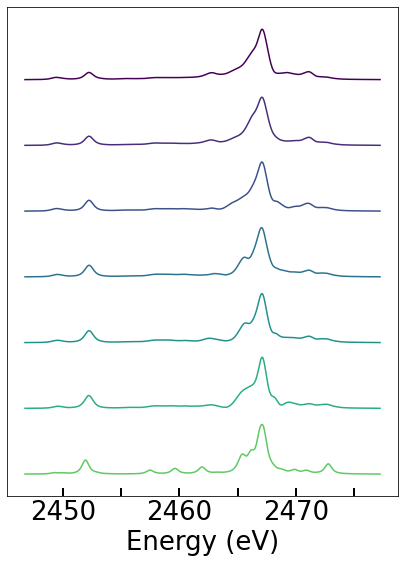

In [82]:
stack_plot(XESenergy[s:e], Recon, Names, '', space=0.5, figsize=(7,9), fontsize=22, leg=0, ncol=1, method='XES')

# Other dimension reduction

In [83]:
# KNN = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(z_mean)
# distances, indices = KNN.kneighbors(z_mean)
# Thank you to:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
#sphx-glr-auto-examples-neighbors-plot-classification-py

def KNN_2D(dim_reducer, train_labels, method, n_neighbors = 40, h = .01, scheme=2, plot=True,
          val=False, normalize=True):

    if val:
        X_train, Y_train = shuffle_xy(X, one_hot_to_num(train_labels))
        train_size = 657
        X_test = X_train[train_size:].copy()
        Y_test = Y_train[train_size:].copy()
        X_train = X_train[:train_size].copy()
        Y_train = Y_train[:train_size].copy()
        
        if method is 'VAE':
            D_train = dim_reducer.predict(X_train, batch_size=20)[0]
            D_test = dim_reducer.predict(X_test, batch_size=20)[0]
        else:
            dim_reducer = dim_reducer.fit(X_train)
            D_train = dim_reducer.transform(X_train)
            D_test = dim_reducer.transform(X_test)
    else:
        X_train, Y_train = shuffle_xy(X, one_hot_to_num(train_labels))
        X_test = TEST_XES.copy()
        
        if method is 'VAE':
            D_train = dim_reducer.predict(X_train, batch_size=20)[0]
            D_test = dim_reducer.predict(X_test, batch_size=5)[0]
        else:
            dim_reducer = dim_reducer.fit(X_train)
            D_train = dim_reducer.transform(X_train)
            D_test = dim_reducer.transform(X_test)
            
        if scheme == 1:
            Y_test = TEST_OXY
        elif scheme == 2:
            Y_test = TEST_TYPE
        else:
            Y_test = TEST_CAT
    
    fontsize=22
    
    if normalize:
        Std = np.std(D_train, axis=0)
        Mean = np.mean(D_train, axis=0)
        D_train -= Mean
        D_train /= Std
        D_test -= Mean
        D_test /= Std   
    
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(D_train, Y_train)
    
    x_min, x_max = np.min(D_train[:,0]), np.max(D_train[:,0])
    y_min, y_max = np.min(D_train[:,1]), np.max(D_train[:,1])
    
    buffer = np.abs(x_max - x_min)*0.05
    h = (np.abs(x_max - x_min) + 2*buffer) / 100
    
    xx, yy = np.meshgrid(np.arange(x_min-buffer, x_max+buffer, h), np.arange(y_min-buffer, y_max+buffer, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # getting test accuracy
    pred = clf.predict(D_test)
    Accuracy = sum(1 for i in range(len(pred)) if pred[i] == Y_test[i])/len(pred)
    markers = []
    for i in range(len(pred)):
        if pred[i] == Y_test[i]:
            markers.append('o')
        else:
            markers.append('x')

    if plot:
        cbar_vis = True
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
        if scheme == 1:
            cmap = ListedColormap([COLORS[0], COLORS[2], COLORS[4]])
            loc = [-1.33, 0, 1.33]
        elif scheme == 2:
            cmap = ListedColormap(COLORS)
        elif scheme == 3:
            Colors = list(COLORMAP(np.arange(1,11)/9))
            # type 1
            Colors[0] = COLORS[0].copy()
            Colors[1] = '#9F5F80'
            # type 2
            Colors[2] = '#03506F'
            Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
            # type 3
            Colors[4] = '#DB6400' 
            Colors[5] = '#ffba93' 
            # type 4
            Colors[6] = '#2b3016' 
            Colors[7] = COLORS[3].copy()
            # type 5
            Colors[8] = '#ac3501'
            Colors[9] = COLORS[4]
            cmap = ListedColormap(Colors)
        
        plt.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.1)

        if scheme == 1:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train*2-4, cmap=cmap)
            ticks=Oxys
            title = 'Oxidation'       
        elif scheme == 2:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            ticks=Types
            loc = [1.4, 2.2, 3, 3.8, 4.6]
            title = 'Types'
        elif scheme == 3:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            cbar_vis = False
            title = 'Category'

        if cbar_vis:
#             cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
#             cbar= plt.colorbar(cax=cbaxes, ticks=ticks)
            cbar= plt.colorbar(ticks=ticks)
            cbar.set_label(title, fontsize=26)
            cbar.set_ticks(loc)
            cbar.ax.tick_params(labelsize=22)
            cbar.set_ticklabels(ticks)
            black_o = mlines.Line2D([], [], color='k', marker='o', linestyle='None', fillstyle='none',
                              markersize=10, label='Correct')
            black_x = mlines.Line2D([], [], color='k', marker='x', linestyle='None', fillstyle='none',
                              markersize=10, label='Incorrect')
            ax.legend(handles=[black_o, black_x], fontsize=22)
        else:
            t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
            t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
            t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
            t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
            t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
            t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
            t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
            t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
            t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
            t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
            space = mpatches.Patch(color='w', label='')
            fig.subplots_adjust(right=0.75)
#             plt.legend(handles=[t1a, t1b, space, t2a, t2b, space, t3a, t3b, space, t4a, t4b, space, t5a, t5b],
#                 fontsize=14, bbox_to_anchor=(1.02, 0.97), borderaxespad=0.)
            
        for i in range(len(D_test)):
            plt.plot(D_test[i, 0], D_test[i, 1], marker=markers[i], c='k', markersize=10, fillstyle='none')

        plt.title(f'{method}: {100*Accuracy:.1f}% Accuracy', fontsize=30)
        plt.axis('off')
        plt.show()
    else:
        if scheme == 1:
            title = 'Oxidation'
        elif scheme == 2:
            title = 'Types'
        else:
            title = 'Category'
        print(f"KNN on {method}: {title} (Accuracy: {Accuracy:.2f})")
        return Accuracy

In [84]:
# KNN = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(z_mean)
# distances, indices = KNN.kneighbors(z_mean)
# Thank you to:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
#sphx-glr-auto-examples-neighbors-plot-classification-py

def KNN_tsne(X_red, train_labels, method, TEST_SIZE, n_neighbors = 40, h = .01, scheme=2, plot=True,
          normalize=True):

    D_train = X_red[:-TEST_SIZE,:]
    Y_train = one_hot_to_num(train_labels)
    
    D_test = X_red[-TEST_SIZE:,:]
        
    if scheme == 1:
        Y_test = TEST_OXY
    elif scheme == 2:
        Y_test = TEST_TYPE
    else:
        Y_test = TEST_CAT
    
    fontsize=22
    
    if normalize:
        Std = np.std(D_train, axis=0)
        Mean = np.mean(D_train, axis=0)
        D_train -= Mean
        D_train /= Std
        D_test -= Mean
        D_test /= Std   
    
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(D_train, Y_train)
    
    x_min, x_max = np.min(D_train[:,0]), np.max(D_train[:,0])
    y_min, y_max = np.min(D_train[:,1]), np.max(D_train[:,1])
    
    buffer = np.abs(x_max - x_min)*0.05
    h = (np.abs(x_max - x_min) + 2*buffer) / 100
    
    xx, yy = np.meshgrid(np.arange(x_min-buffer, x_max+buffer, h), np.arange(y_min-buffer, y_max+buffer, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # getting test accuracy
    pred = clf.predict(D_test)
    Accuracy = sum(1 for i in range(len(pred)) if pred[i] == Y_test[i])/len(pred) 
    markers = []
    for i in range(len(pred)):
        if pred[i] == Y_test[i]:
            markers.append('o')
        else:
            markers.append('x')

    if plot:
        cbar_vis = True
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
#         fig, ax = plt.subplots(figsize=(12, 8))
        if scheme == 1:
            cmap = ListedColormap([COLORS[0], COLORS[2], COLORS[4]])
            loc = [-1.33, 0, 1.33]
        elif scheme == 2:
            cmap = ListedColormap(COLORS)
        elif scheme == 3:
            Colors = list(COLORMAP(np.arange(1,11)/9))
            # type 1
            Colors[0] = COLORS[0].copy()
            Colors[1] = '#9F5F80'
            # type 2
            Colors[2] = '#03506F'
            Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
            # type 3
            Colors[4] = '#DB6400' 
            Colors[5] = '#ffba93' 
            # type 4
            Colors[6] = '#2b3016' 
            Colors[7] = COLORS[3].copy()
            # type 5
            Colors[8] = '#ac3501'
            Colors[9] = COLORS[4]
            cmap = ListedColormap(Colors)
        
        plt.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.1)

        if scheme == 1:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train*2-4, cmap=cmap)
            ticks=Oxys
            title = 'Oxidation'       
        elif scheme == 2:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            ticks=Types
            loc = [1.4, 2.2, 3, 3.8, 4.6]
            title = 'Types'
        elif scheme == 3:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            cbar_vis = False
            title = 'Category'

        if cbar_vis:
#             cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
#             cbar= plt.colorbar(cax=cbaxes, ticks=ticks)
            cbar= plt.colorbar(ticks=ticks)
            cbar.set_label(title, fontsize=26)
            cbar.set_ticks(loc)
            cbar.ax.tick_params(labelsize=22)
            cbar.set_ticklabels(ticks)
            black_o = mlines.Line2D([], [], c='k', marker='o', linestyle='None', fillstyle='none',
                              markersize=10, label='Correct')
            black_x = mlines.Line2D([], [], c='k', marker='x', linestyle='None', fillstyle='none',
                              markersize=10, label='Incorrect')
            ax.legend(handles=[black_o, black_x], fontsize=22)
        else:
            t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
            t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
            t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
            t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
            t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
            t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
            t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
            t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
            t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
            t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
            space = mpatches.Patch(color='w', label='')
            
            plt.legend(handles=[t1a, t1b, t2a, t2b, t3a, t3b, t4a, t4b, t5a, t5b], ncol=5,
                fontsize=20, bbox_to_anchor=(0., 1.2, 1., 0.025), loc=2, borderaxespad=0.)
            fig.subplots_adjust(right=0.75)
            
        for i in range(len(D_test)):
            plt.plot(D_test[i, 0], D_test[i, 1], marker=markers[i], c='k', markersize=10, fillstyle='none')

        plt.title(f'{method}: {100*Accuracy:.1f}% Accuracy', fontsize=30)
        plt.axis('off')
        plt.show()
    else:
        if scheme == 1:
            title = 'Oxidation'
        elif scheme == 2:
            title = 'Types'
        else:
            title = 'Category'
        print(f"KNN on {method}: {title} (Accuracy: {Accuracy:.2f})")
        return Accuracy

In [85]:
fastICA = FastICA(n_components=2)
fastICA = fastICA.fit(X)
X_FastICA = fastICA.fit_transform(X)
TEST_X_FastICA = fastICA.transform(TEST_XES)

fa = FactorAnalysis(n_components=2)
fa = fa.fit(X)
X_FA = fa.transform(X)
TEST_X_FA = fa.transform(TEST_XES)

nmf = NMF(n_components=2)
nmf = nmf.fit(X)
X_NMF = nmf.transform(X)
TEST_X_NMF = nmf.transform(TEST_XES)

pca = PCA(n_components=2)
pca = pca.fit(X)
X_PCA = pca.transform(X)
TEST_X_PCA = pca.transform(TEST_XES)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XES, batch_size=5)[0]

tsne = TSNE(n_components=2, perplexity=15, random_state=30)
X_TSNE = tsne.fit_transform(X)

(3,)


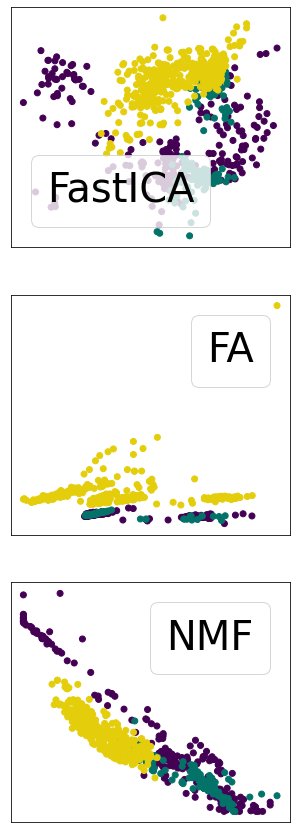

In [107]:
def plot_dim_red_stack(PROPERTY, X_reds, Y, methods, fontsize=28):
    
    n = len(X_reds)
    
    Colors = list(COLORMAP(np.arange(1,11)/9))
    for i in range(10):
        Colors[i] = (128/255,128/255,128/255,0.2)
            
    # type 1
    Colors[0] = COLORS[0].copy()
    Colors[1] = '#9F5F80'
    # type 2
    Colors[2] = '#03506F'
    Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
    # type 3
    Colors[4] = '#DB6400' #'#ac3501'
    Colors[5] = '#ffba93' #'#f89345'
    # type 4
    Colors[6] = '#2b3016' 
    Colors[7] = COLORS[3].copy()
    # type 5
    Colors[8] = '#ac3501'
    Colors[9] = COLORS[4]

    fig, axes = plt.subplots(figsize=(5,15), nrows=n)
    
    if PROPERTY == 'oxy':
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        
        for i in range(n):
            axes[i].scatter(X_reds[i][:, 0], X_reds[i][:, 1], c=one_hot_to_num(Y)*2-4, cmap=cmap)
        
        ticks=Oxys
        title = 'Oxidation'
        loc = [-1.33, 0, 1.33]
        label = title
        
    elif PROPERTY == 'category':
        
        title = "Category"
        label = title
            
        title = 'Conjugated vs Not Conjugated'
            
        t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
        t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
        t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
        t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
        t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
        t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
        t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
        t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
        t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
        t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
        space = mpatches.Patch(color='w', label='')
            
        fig.subplots_adjust(right=0.75, hspace=0.0)
            
#         plt.legend(handles=[t1a, t1b, space, t2a, t2b, space, t3a, t3b, space, t4a, t4b, space, t5a, t5b],
#             fontsize=14, bbox_to_anchor=(1.02, 0.97), loc=leg, borderaxespad=0.)
        if show_legend:
            plt.legend(handles=[t1a, t1b, t2a, t2b, t3a, t3b, t4a, t4b, t5a, t5b], ncol=5,
                fontsize=18, bbox_to_anchor=(0., 1.13, 1., 0.025), loc=leg, borderaxespad=0.)
            
        cbar_vis = False
        
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=one_hot_to_num(Y), cmap=cmap)
        
    elif PROPERTY == 'Type':
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=one_hot_to_num(Y), cmap=cmap)
        ticks=Types
        title = "Type"
        loc = [1.4, 2.2, 3, 3.8, 4.6]
        label = title

#     cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
#     cbar = plt.colorbar(cax=cbaxes, ticks=ticks)
#     cbar.set_label(label, fontsize=26)
#     cbar.set_ticks(loc)
#     cbar.cax.tick_params(labelsize=22)
#     cbar.set_ticklabels(ticks)
    
    for i,ax in enumerate(axes):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        legend = ax.legend([methods[i]], handlelength=0, handletextpad=0, fancybox=True, fontsize=fontsize+12)
        for item in legend.legendHandles:
            item.set_visible(False)

    plt.show()
    
    
plot_dim_red_stack('oxy', [X_FastICA, X_FA, X_NMF], Labels[1], ['FastICA', 'FA', 'NMF'])

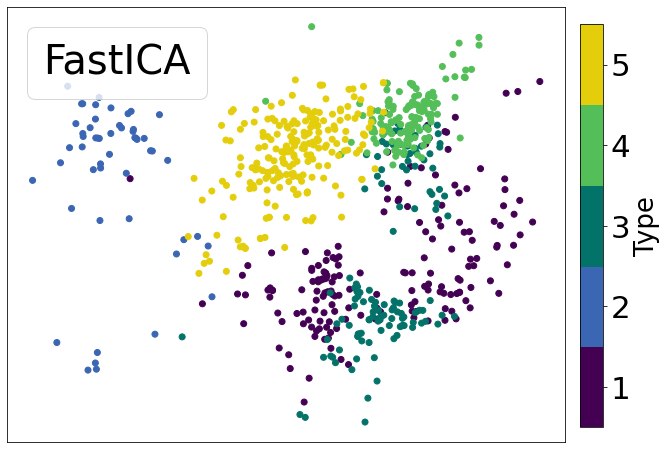

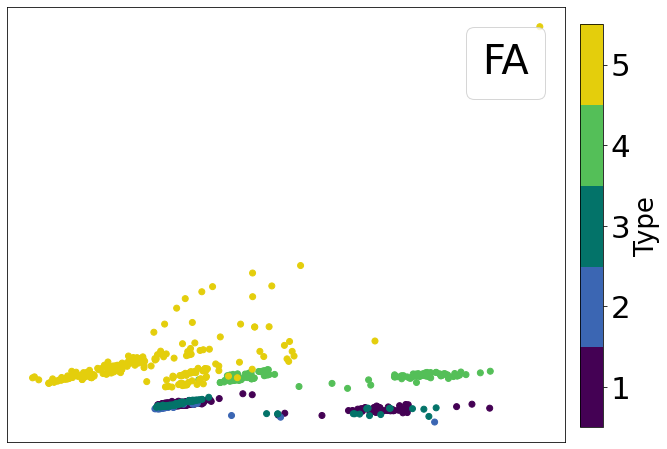

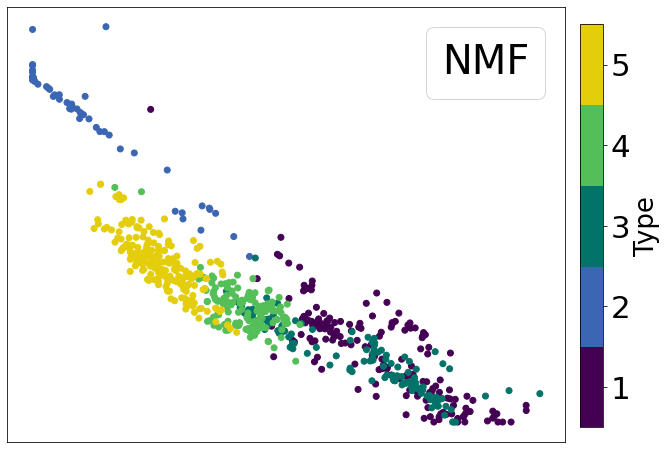

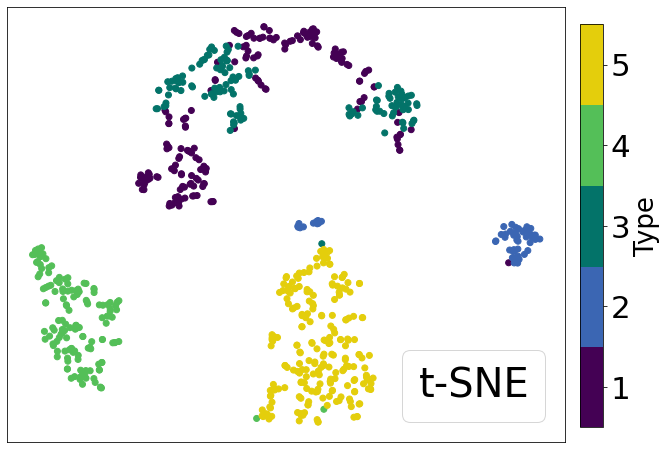

In [88]:
plot_dim_red('Type', X_FastICA, Labels[1],'FastICA')
plot_dim_red('Type', X_FA, Labels[1],'FA')
plot_dim_red('Type', X_NMF, Labels[1],'NMF')

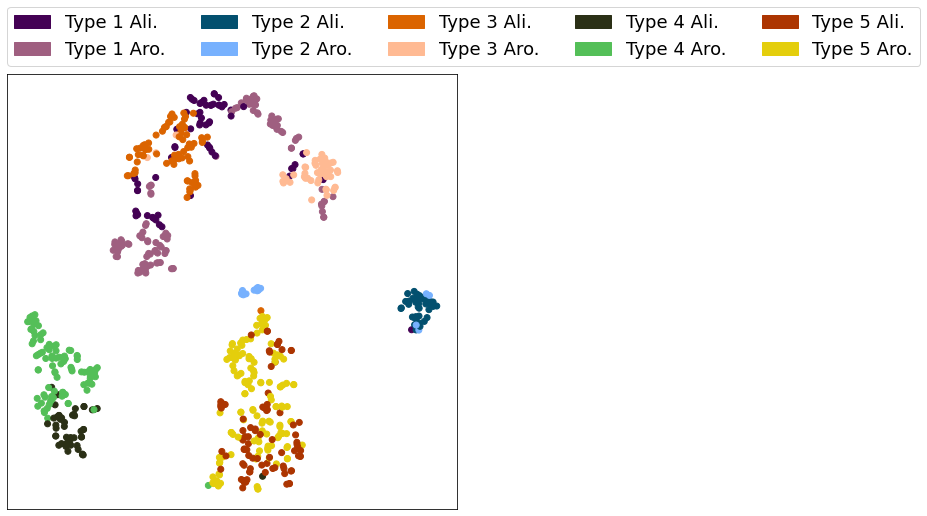

In [89]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('category', X_TSNE, Labels[2],'t-SNE')

In [91]:
fastICA = FastICA(n_components=2)

fa = FactorAnalysis(n_components=2)

nmf = NMF(n_components=2)

pca = PCA(n_components=2)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XES)[0]

tsne = TSNE(n_components=2, perplexity=15, random_state=30)
everything = list(X)
for x in TEST_XES:
    everything.append(x)
everything = np.array(everything)
X_TSNE = tsne.fit_transform(everything)
TEST_SIZE = len(TEST_XES)

In [92]:
Acc = [[],[],[]]
print("Oxidation:")
neis = 20
i = 0
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis, plot=False))
print("\nType:")
neis = 20
i = 1
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis, plot=False))
print("\nAro:")
neis = 10
i = 2
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis, plot=False))

Oxidation:
KNN on VAE: Oxidation (Accuracy: 1.00)
KNN on PCA: Oxidation (Accuracy: 0.85)
KNN on FastICA: Oxidation (Accuracy: 0.85)
KNN on FA: Oxidation (Accuracy: 1.00)
KNN on NMF: Oxidation (Accuracy: 0.88)
KNN on t-SNE: Oxidation (Accuracy: 1.00)

Type:
KNN on VAE: Types (Accuracy: 0.85)
KNN on PCA: Types (Accuracy: 0.69)
KNN on FastICA: Types (Accuracy: 0.69)
KNN on FA: Types (Accuracy: 0.85)
KNN on NMF: Types (Accuracy: 0.65)
KNN on t-SNE: Types (Accuracy: 0.88)

Aro:
KNN on VAE: Category (Accuracy: 0.67)
KNN on PCA: Category (Accuracy: 0.60)
KNN on FastICA: Category (Accuracy: 0.60)
KNN on FA: Category (Accuracy: 0.77)
KNN on NMF: Category (Accuracy: 0.52)
KNN on t-SNE: Category (Accuracy: 0.79)


In [ ]:
bar_chart(Acc, [100,90.4,67.3], mode='XES')

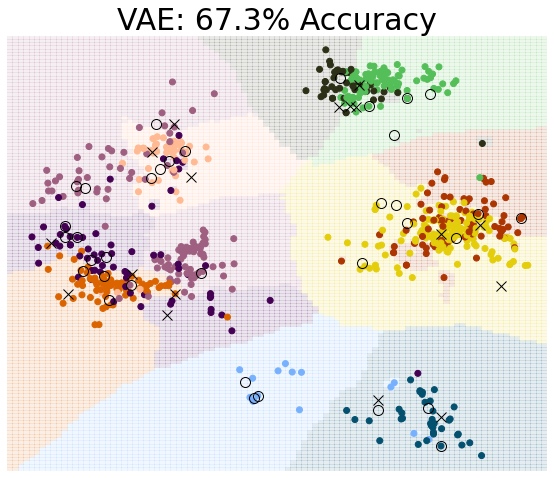

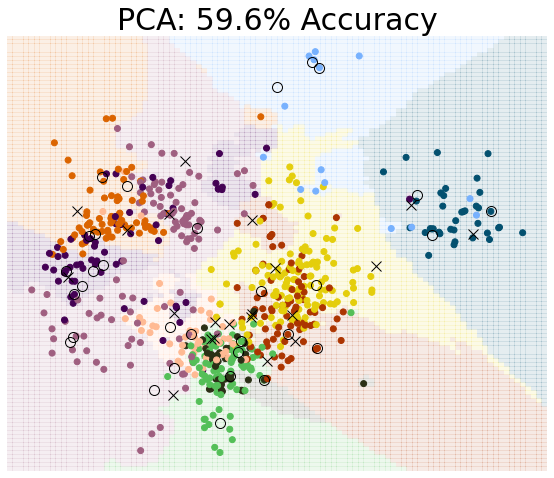

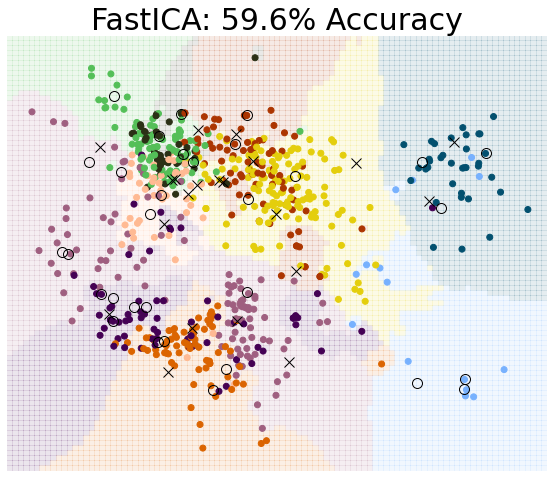

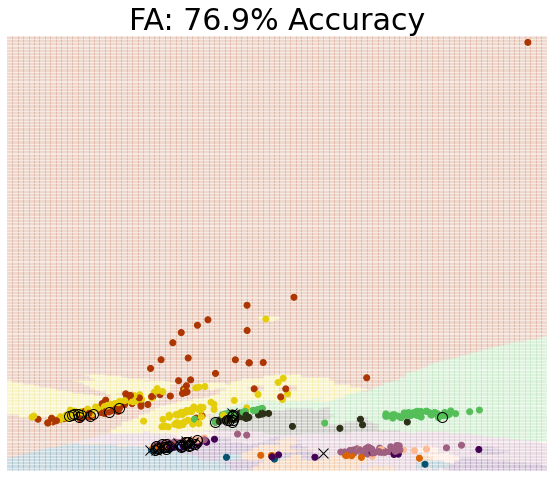

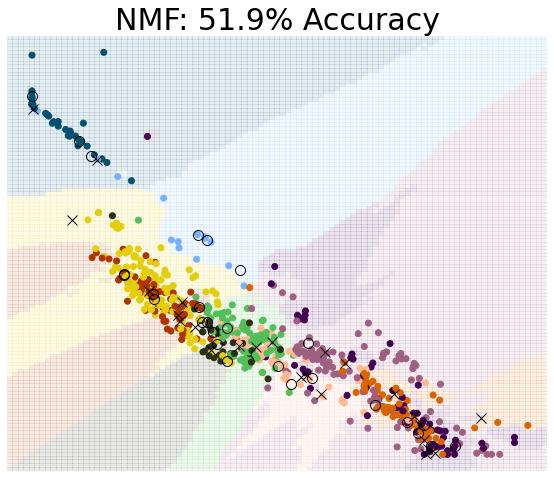

In [94]:
neis = 10
i = 2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis)
    KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis)
    KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis)
    KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis)
    KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis)
    KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis)